# Analyzing patient data with BigQuery and Datalab

# Preface
Depending on where you choose to run the notebook you might need the packages below
!pip install google-cloud-storage
!pip install google-cloud-bigquery

Specifically for datalab, ensure the compute service account has the appropriate BigQuery roles. This notebooks reads and creates BiqQuery Tables.

# REFERENCE:
# https://github.com/google/fhir/tree/master/examples/bigquery

In [169]:
import os
GCP_PROJECT = 'calcium-vial-225816'
GCS_BUCKET = 'gs://demo-health-bkt'
GCS_FHIR_DATA = GCS_BUCKET + '/fhir/json/'
GCS_REGION = 'us-central1'
BQ_DATASET = 'synthea'
BQ_SINUSTABLE = 'cohort_sinus'
os.putenv("REGION", GCS_REGION)
os.putenv("BQ_DATASET", BQ_DATASET)
os.putenv("BQ_SINUSTABLE", BQ_SINUSTABLE)
os.putenv("GOOGLE_CLOUD_PROJECT", GCP_PROJECT)

In [170]:
%load_ext google.cloud.bigquery

The google.cloud.bigquery extension is already loaded. To reload it, use:
  %reload_ext google.cloud.bigquery


## Query the most frequent condition for each gender

In [ ]:
%%bigquery
SELECT
  gender gender,
  APPROX_TOP_COUNT(code.text, 2) AS top_conditions
FROM
  synthea.Condition c
JOIN
  synthea.Patient p
ON
  c.subject.patientId=p.id
GROUP BY
  1

## Query the average time spent for each encounter class

In [ ]:
%%bigquery
SELECT
  class.code encounter_class,
  ROUND(AVG(TIMESTAMP_DIFF(TIMESTAMP(period.end), TIMESTAMP(period.start), MINUTE)),1) as avg_minutes
FROM
  synthea.Encounter
WHERE
  period.end >= period.start
GROUP BY
  1
ORDER BY
  2 DESC

## Query the top 4 cholesterol related values 
--(LOINC:Logical Observation Identifiers Names and Codes)

In [ ]:
%%bigquery
SELECT cc.code AS loinc_code,
  cc.display AS loinc_name,
  approx_quantiles(round(o.value.quantity.value,1),4) as quantiles,
  COUNT(*) AS num_obs
FROM
  synthea.Observation o, o.code.coding cc
WHERE
  cc.system LIKE '%loinc%' AND lower(cc.display) LIKE '%cholesterol%'
GROUP BY 1,2
ORDER BY 4 desc

## Finding observations related to A1c test results in the year 2017 

In [ ]:
%%bigquery
SELECT obs.subject.patientId,
       obs.code.coding[OFFSET(0)].code AS code, 
       obs.value.quantity.value, 
       obs.effective.dateTime 
FROM synthea.Observation obs
WHERE obs.code.coding[OFFSET(0)].display 
LIKE '%A1c%' 
AND 
obs.effective.dateTime LIKE '%2017%' 

## Is there a change and if so what is the change in diabests risk over the last N years (number of patients and the A1c value)?

Text(0,0.5,'Average')

/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


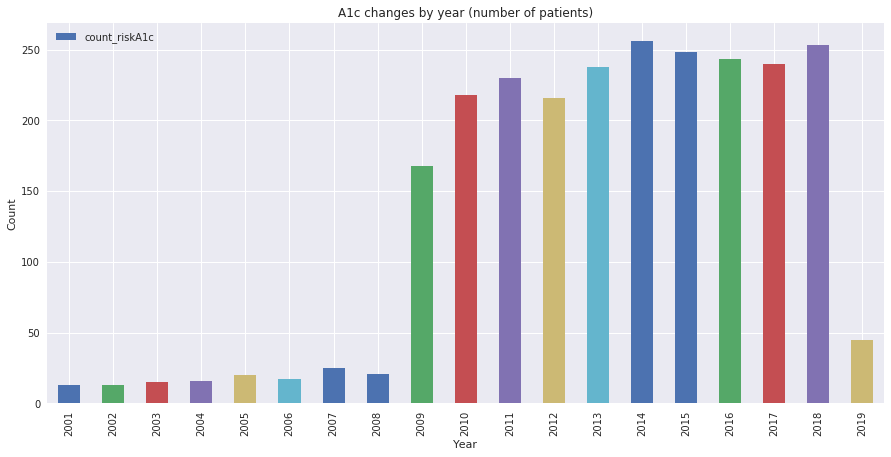

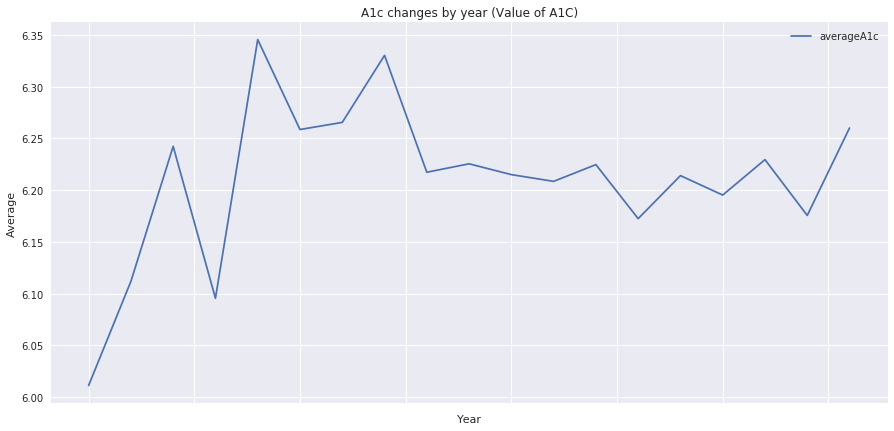

In [171]:
import pandas
from google.cloud import bigquery
client = bigquery.Client()
sql = """
SELECT COUNT(*) as count_riskA1c,
       SUBSTR(obs.effective.dateTime, 0, 4) as year,
       AVG(obs.value.quantity.value) as averageA1c
FROM synthea.Observation obs
WHERE obs.code.coding[OFFSET(0)].display LIKE '%A1c%' 
   AND obs.value.quantity.value > 5.1
   AND SUBSTR(obs.effective.dateTime, 0, 4) > '2000'
GROUP BY year
ORDER BY year
"""
df = client.query(sql).to_dataframe()
ax = df.plot(kind='bar', x='year', y='count_riskA1c', figsize=(15,7))
ax.set_title('A1c changes by year (number of patients)')
ax.set_xlabel('Year')
ax.set_ylabel('Count');

bx = df.plot(kind='line', x='year', y='averageA1c', figsize=(15,7))
bx.set_title('A1c changes by year (Value of A1C)')
bx.set_xlabel('Year')
bx.set_ylabel('Average')

# Exploring cohorts for a given condition

## Exploring patients and possible cohorts ..1

In [172]:
%%bigquery
SELECT
  id cond_id,
  subject.patientId person_ref,
  coding.system,
  coding.code,
  coding.display
FROM synthea.Condition cond
CROSS JOIN UNNEST(cond.code.coding) as coding 


,cond_id,person_ref,system,code,display
0,cec86db6-f74a-4d84-a089-54095f9f71dc,bc528f57-59d7-4af0-9a6e-3fa96dbecb14,http://snomed.info/sct,10509002,Acute bronchitis (disorder)
1,40d72b0c-99fb-4f6f-9ed0-1538c474307f,bc528f57-59d7-4af0-9a6e-3fa96dbecb14,http://snomed.info/sct,10509002,Acute bronchitis (disorder)
2,66e89d5d-8123-456a-b184-49fb0c2c675b,4d47ebbd-0423-4194-8986-4e15768250f5,http://snomed.info/sct,10509002,Acute bronchitis (disorder)
3,e8174420-36bf-4a3b-8251-1fa2aad7afe2,4639d047-977e-4ef6-8cd6-66b0b7273a03,http://snomed.info/sct,10509002,Acute bronchitis (disorder)
4,cd47a31d-1d40-4e7f-8e40-55268f0c2578,6bdedaff-7fff-4a45-9494-5cff66f111f4,http://snomed.info/sct,10509002,Acute bronchitis (disorder)
5,ef5f85b6-79ef-43c5-9a64-d59df9ad4deb,e31f2325-cafd-469d-91c9-219bd33ce88f,http://snomed.info/sct,10509002,Acute bronchitis (disorder)
6,5d20056d-3a8f-447d-8cbc-5a6219217f97,0a3d6699-f20c-459f-be2a-afdd9caf7885,http://snomed.info/sct,10509002,Acute bronchitis (disorder)
7,d610a160-42fc-4730-856b-ffd6a0665618,0a3d6699-f20c-459f-be2a-afdd9caf7885,http://snomed.info/sct,10509002,Acute bronchitis (disorder)
8,11386051-c464-4aa4-98ba-52f5cd96ec29,69edfa5b-863e-46e3-8b7f-9ad28384b4b7,http://snomed.info/sct,10509002,Acute bronchitis (disorder)
9,f71fcea4-3e84-4c0b-bd59-e0831fc02123,89dd83a3-7c26-4683-987a-877e4171b430,http://snomed.info/sct,10509002,Acute bronchitis (disorder)


## Exploring patients and possible cohorts ..2

In [173]:
%%bigquery
SELECT
  count(*) AS count,
  coding.display AS condition
FROM synthea.Condition cond
CROSS JOIN UNNEST(cond.code.coding) as coding 
GROUP BY condition 


,count,condition
0,607,Acute bronchitis (disorder)
1,2,Fracture of vertebral column without spinal co...
2,38,Fracture of ankle
3,22,Atopic dermatitis
4,10,Rupture of patellar tendon
5,15,Fracture of rib
6,25,Blighted ovum
7,1,"Major depression, single episode"
8,71,Sinusitis (disorder)
9,24,Cystitis


# Building a cohort for a given condition

In [174]:
from google.cloud import bigquery
client = bigquery.Client()
dataset_id = BQ_DATASET

job_config = bigquery.QueryJobConfig()
# Set the destination table
table_ref = client.dataset(dataset_id).table(BQ_SINUSTABLE)
job_config.destination = table_ref
sql = """
SELECT
  id cond_id,
  subject.patientId person_ref,
  coding.system,
  coding.code,
  coding.display
FROM synthea.Condition cond
CROSS JOIN UNNEST(cond.code.coding) as coding 
WHERE coding.display LIKE 'Chronic sinusitis (disorder)'

"""
# Start the query, passing in the extra configuration.
query_job = client.query(
    sql,
    # Location must match that of the dataset(s) referenced in the query
    # and of the destination table.
    location='US',
    job_config=job_config)  # API request - starts the query

query_job.result()  # Waits for the query to finish
print('Query results loaded to table {}'.format(table_ref.path))

Query results loaded to table /projects/calcium-vial-225816/datasets/synthea/tables/cohort_sinus
